# Insights

Question: Does a county's temperature have an affect on it's infection rate (amount of confirmed cases)?

Analysis:
Inconclusive based on incomplete data. The regressions below suggest weather temperatures and daily infection rates are not strongly correlated. The country with the strongest correlation was Germany (see  figure 6). 


Limitations:
-Don't have enough weather data by country -Only representing one type of weather statistic (temperature) Limited data on COVID19 generally (would need multiple years to detect if this will be seasonal
-Variation in countries (ideally would like to represent all continents) 
-Weather anomalies (if any) 
-Lag for testing time
-Limited testing resources Limitations

Data Cleanup Process

To investigate if the potential relationship between temperature and amount of infections, I needed two combine two data sets.


Weather Data Source: 
NOAA: https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND
Note: Individal reports were pulled for each country. US weather data was inaccessible (10K cap), so NY State data was pulled and is representing the US. 

Specifications: Daily Average Temperatures we requested between 1/1/20- 3/15/20.
The earliest weather data begins with Malaysia on 1/25/10 and extends until 3/9/20 for multiple countries. 


Data Source for COVID 19 Information:
The COVID_19 data set has daily level information on the number of affected cases, deaths and recovery cases from the 2019 novel coronavirus. 

Kaggle: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
Note: Confirmed Cases shows the cumulative amount of cases by day (resets each day). 


Kaggle Supplemental Data:
Johns Hopkins University: https://github.com/CSSEGISandData/COVID-19
MoBS lab - https://www.mobs-lab.org/2019ncov.html
World Health Organization (WHO): https://www.who.int/
DXY.cn. Pneumonia. 2020. http://3g.dxy.cn/newh5/view/pneumonia.
BNO News: https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/
National Health Commission of the People’s Republic of China (NHC):
http://www.nhc.gov.cn/xcs/yqtb/list_gzbd.shtml
China CDC (CCDC): http://weekly.chinacdc.cn/news/TrackingtheEpidemic.htm
Hong Kong Department of Health: https://www.chp.gov.hk/en/features/102465.html
Macau Government: https://www.ssm.gov.mo/portal/
Taiwan CDC: https://sites.google.com/cdc.gov.tw/2019ncov/taiwan?authuser=0
US CDC: https://www.cdc.gov/coronavirus/2019-ncov/index.html
Government of Canada: https://www.canada.ca/en/public-health/services/diseases/coronavirus.html
Australia Government Department of Health: https://www.health.gov.au/news/coronavirus-update-at-a-glance
European Centre for Disease Prevention and Control (ECDC): https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases
Ministry of Health Singapore (MOH): https://www.moh.gov.sg/covid-19
Italy Ministry of Health: http://www.salute.gov.it/nuovocoronavirus

In [2]:
#import dependencies
import csv
import pandas as pd
import json
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import requests
import time
from scipy.stats import linregress

%matplotlib inline
%matplotlib notebook

In [3]:
#Read in weather data file

csv_path = "../Notebooks/Master Countries Avg Temps.csv"

Temperature = pd.read_csv(csv_path)

df_temperature = Temperature.groupby(['Country', 'date']).max()
df_temperature = df_temperature.reset_index()

In [4]:
#Read in COVID 19 data file
csv_path = "../Notebooks/covid_19_data_sr.csv"
df_covid = pd.read_csv(csv_path)

In [5]:
#Rename "Observation Column" to "date" in preparation for merging the data files

df_covid = df_covid.rename(columns={"ObservationDate": "date"})
df_covid

,SNo,date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1.0,1/22/20,Anhui,Mainland China,1/22/20,1.0,0.0,0.0
1,2.0,1/22/20,Beijing,Mainland China,1/22/20,14.0,0.0,0.0
2,3.0,1/22/20,Chongqing,Mainland China,1/22/20,6.0,0.0,0.0
3,4.0,1/22/20,Fujian,Mainland China,1/22/20,1.0,0.0,0.0
4,5.0,1/22/20,Gansu,Mainland China,1/22/20,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
6111,6153.0,3/16/20,NaN,The Bahamas,3/16/20,1.0,0.0,0.0
6112,6157.0,3/16/20,Virgin Islands,US,3/16/20,1.0,0.0,0.0
6113,6158.0,3/16/20,Cayman Islands,UK,3/16/20,1.0,1.0,0.0
6114,5910.0,3/16/20,New York,US,3/16/20,967.0,10.0,0.0


In [6]:
#Merge the weather & covid data

Merged_Final = df_temperature.merge(df_covid, on=["Country", "date"],how="inner")
Merged_Final

,Country,date,Avg Temp (F),SNo,Province/State,Last Update,Confirmed,Deaths,Recovered
0,Germany,2/1/20,55,531.0,NaN,2/1/20,8.0,0.0,0.0
1,Germany,2/10/20,52,1162.0,NaN,2/9/20,14.0,0.0,0.0
2,Germany,2/11/20,45,1234.0,NaN,2/11/20,16.0,0.0,0.0
3,Germany,2/12/20,43,1307.0,NaN,2/11/20,16.0,0.0,0.0
4,Germany,2/13/20,45,1380.0,NaN,2/13/20,16.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
263,UK,3/5/20,43,3429.0,NaN,3/5/20,115.0,1.0,8.0
264,UK,3/6/20,45,3598.0,NaN,3/6/20,163.0,2.0,8.0
265,UK,3/7/20,50,3795.0,NaN,3/7/20,206.0,2.0,18.0
266,UK,3/8/20,50,4018.0,NaN,3/8/20,273.0,3.0,18.0


In [7]:
#Use a function to calculate the daily change in confirmed cases (infection), deaths and recovered cases
#Clean up the tables by ensuring there aren't any negative values (turn to zero) and then omit the zero values 
#Organize by sorting on the date

def find_daily_cases(df, country_name: str):
    df_cur = df[df.Country == country_name]
    
    df_cur['date'] = pd.to_datetime(df['date'])
    
    df_cur.sort_values(by='date')
    df_cur['daily_confirm'] = df_cur.Confirmed.diff()
    df_cur['daily_confirm'] = df_cur.daily_confirm.fillna(0)
    df_cur=df_cur.loc[df_cur.daily_confirm>0]
    
    df_cur['death_confirm'] = df_cur.Deaths.diff()
    df_cur['death_confirm'] = df_cur.death_confirm.fillna(0)
    
    df_cur['recover_confirm'] = df_cur.Recovered.diff()
    df_cur['recover_confirm'] = df_cur.recover_confirm.fillna(0)
    
    return df_cur

In [8]:
#Create invidivdual dataframes for each country
#NY is NOT a country, but is represntative of the US due to the abundance of cases throughout all areas of NY

df_italy = find_daily_cases(Merged_Final, 'Italy')
df_italy

df_ny = find_daily_cases(Merged_Final, 'New York')
df_ny

df_swd = find_daily_cases(Merged_Final, 'Sweden')
df_swd

df_mly = find_daily_cases(Merged_Final, 'Malaysia')
df_mly

df_germ = find_daily_cases(Merged_Final, 'Germany')
df_germ

df_uk = find_daily_cases(Merged_Final, 'UK')
df_uk

df_spain = find_daily_cases(Merged_Final, 'Spain')


/Users/star/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/star/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/star/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [9]:
#Concatenate to have one table with all countries/one graph with all countries

total_df = pd.concat([df_italy,df_ny, df_swd, df_mly, df_germ, df_uk, df_spain])
total_df

,Country,date,Avg Temp (F),SNo,Province/State,Last Update,Confirmed,Deaths,Recovered,daily_confirm,death_confirm,recover_confirm
46,Italy,2020-02-10,60,1173.0,NaN,2/7/20,3.0,0.0,0.0,1.0,0.0,0.0
57,Italy,2020-02-20,58,1917.0,NaN,2/7/20,3.0,0.0,0.0,1.0,0.0,0.0
58,Italy,2020-02-21,58,1980.0,NaN,2/21/20,20.0,1.0,0.0,17.0,1.0,0.0
59,Italy,2020-02-22,59,2061.0,NaN,2/22/20,62.0,2.0,1.0,42.0,1.0,1.0
60,Italy,2020-02-23,59,2133.0,NaN,2/23/20,155.0,3.0,2.0,93.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
179,Spain,2020-03-05,68,3419.0,NaN,3/5/20,259.0,3.0,2.0,37.0,1.0,0.0
180,Spain,2020-03-06,67,3589.0,NaN,3/6/20,400.0,5.0,2.0,141.0,2.0,0.0
181,Spain,2020-03-07,67,3785.0,NaN,3/7/20,500.0,10.0,30.0,100.0,5.0,28.0
182,Spain,2020-03-08,69,4007.0,NaN,3/8/20,673.0,17.0,30.0,173.0,7.0,0.0


# Data Analysis 

In [10]:
#Data exploration
#View sample sizes after cleaning and average temps for each country

print(total_df["Country"].value_counts())

grouped = total_df.groupby("Country")
avg_temp_all = grouped["Avg Temp (F)"].mean()

start_date_all = grouped["date"].first()
end_date_all = grouped["date"].last()

print(avg_temp_all,start_date_all,end_date_all)

Italy       26
UK          26
Germany     25
Spain       22
Malaysia    11
New York    10
Sweden       3
Name: Country, dtype: int64
Country
Germany     48.480000
Italy       59.076923
Malaysia    81.090909
New York    49.000000
Spain       68.318182
Sweden      25.666667
UK          47.115385
Name: Avg Temp (F), dtype: float64 Country
Germany    2020-02-10
Italy      2020-02-10
Malaysia   2020-01-25
New York   2020-03-11
Spain      2020-02-10
Sweden     2020-02-26
UK         2020-02-10
Name: date, dtype: datetime64[ns] Country
Germany    2020-03-09
Italy      2020-03-09
Malaysia   2020-02-08
New York   2020-03-09
Spain      2020-03-09
Sweden     2020-02-29
UK         2020-03-09
Name: date, dtype: datetime64[ns]


In [23]:
#Use function to efficiently label multiple graphs

def plotRegression(axes, x, y, graph_title='', xlabel='', ylabel='', labelpos=(0,0)):
    axes.scatter(x,y)
    slope, intercept, rvalue, pvalue, stderr = linregress(x,y)
    lineeq = f"y = {slope:.2f}x + {intercept:.2f}\nr-squared: {rvalue**2:.2f}\nn: {len(x)}"
    axes.annotate(lineeq, labelpos, color='red')
    axes.plot(x.sort_values(), np.array(x.sort_values()) * slope + intercept, 'r-')
    axes.set_title(graph_title, fontsize=14)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)

<IPython.core.display.Javascript object>


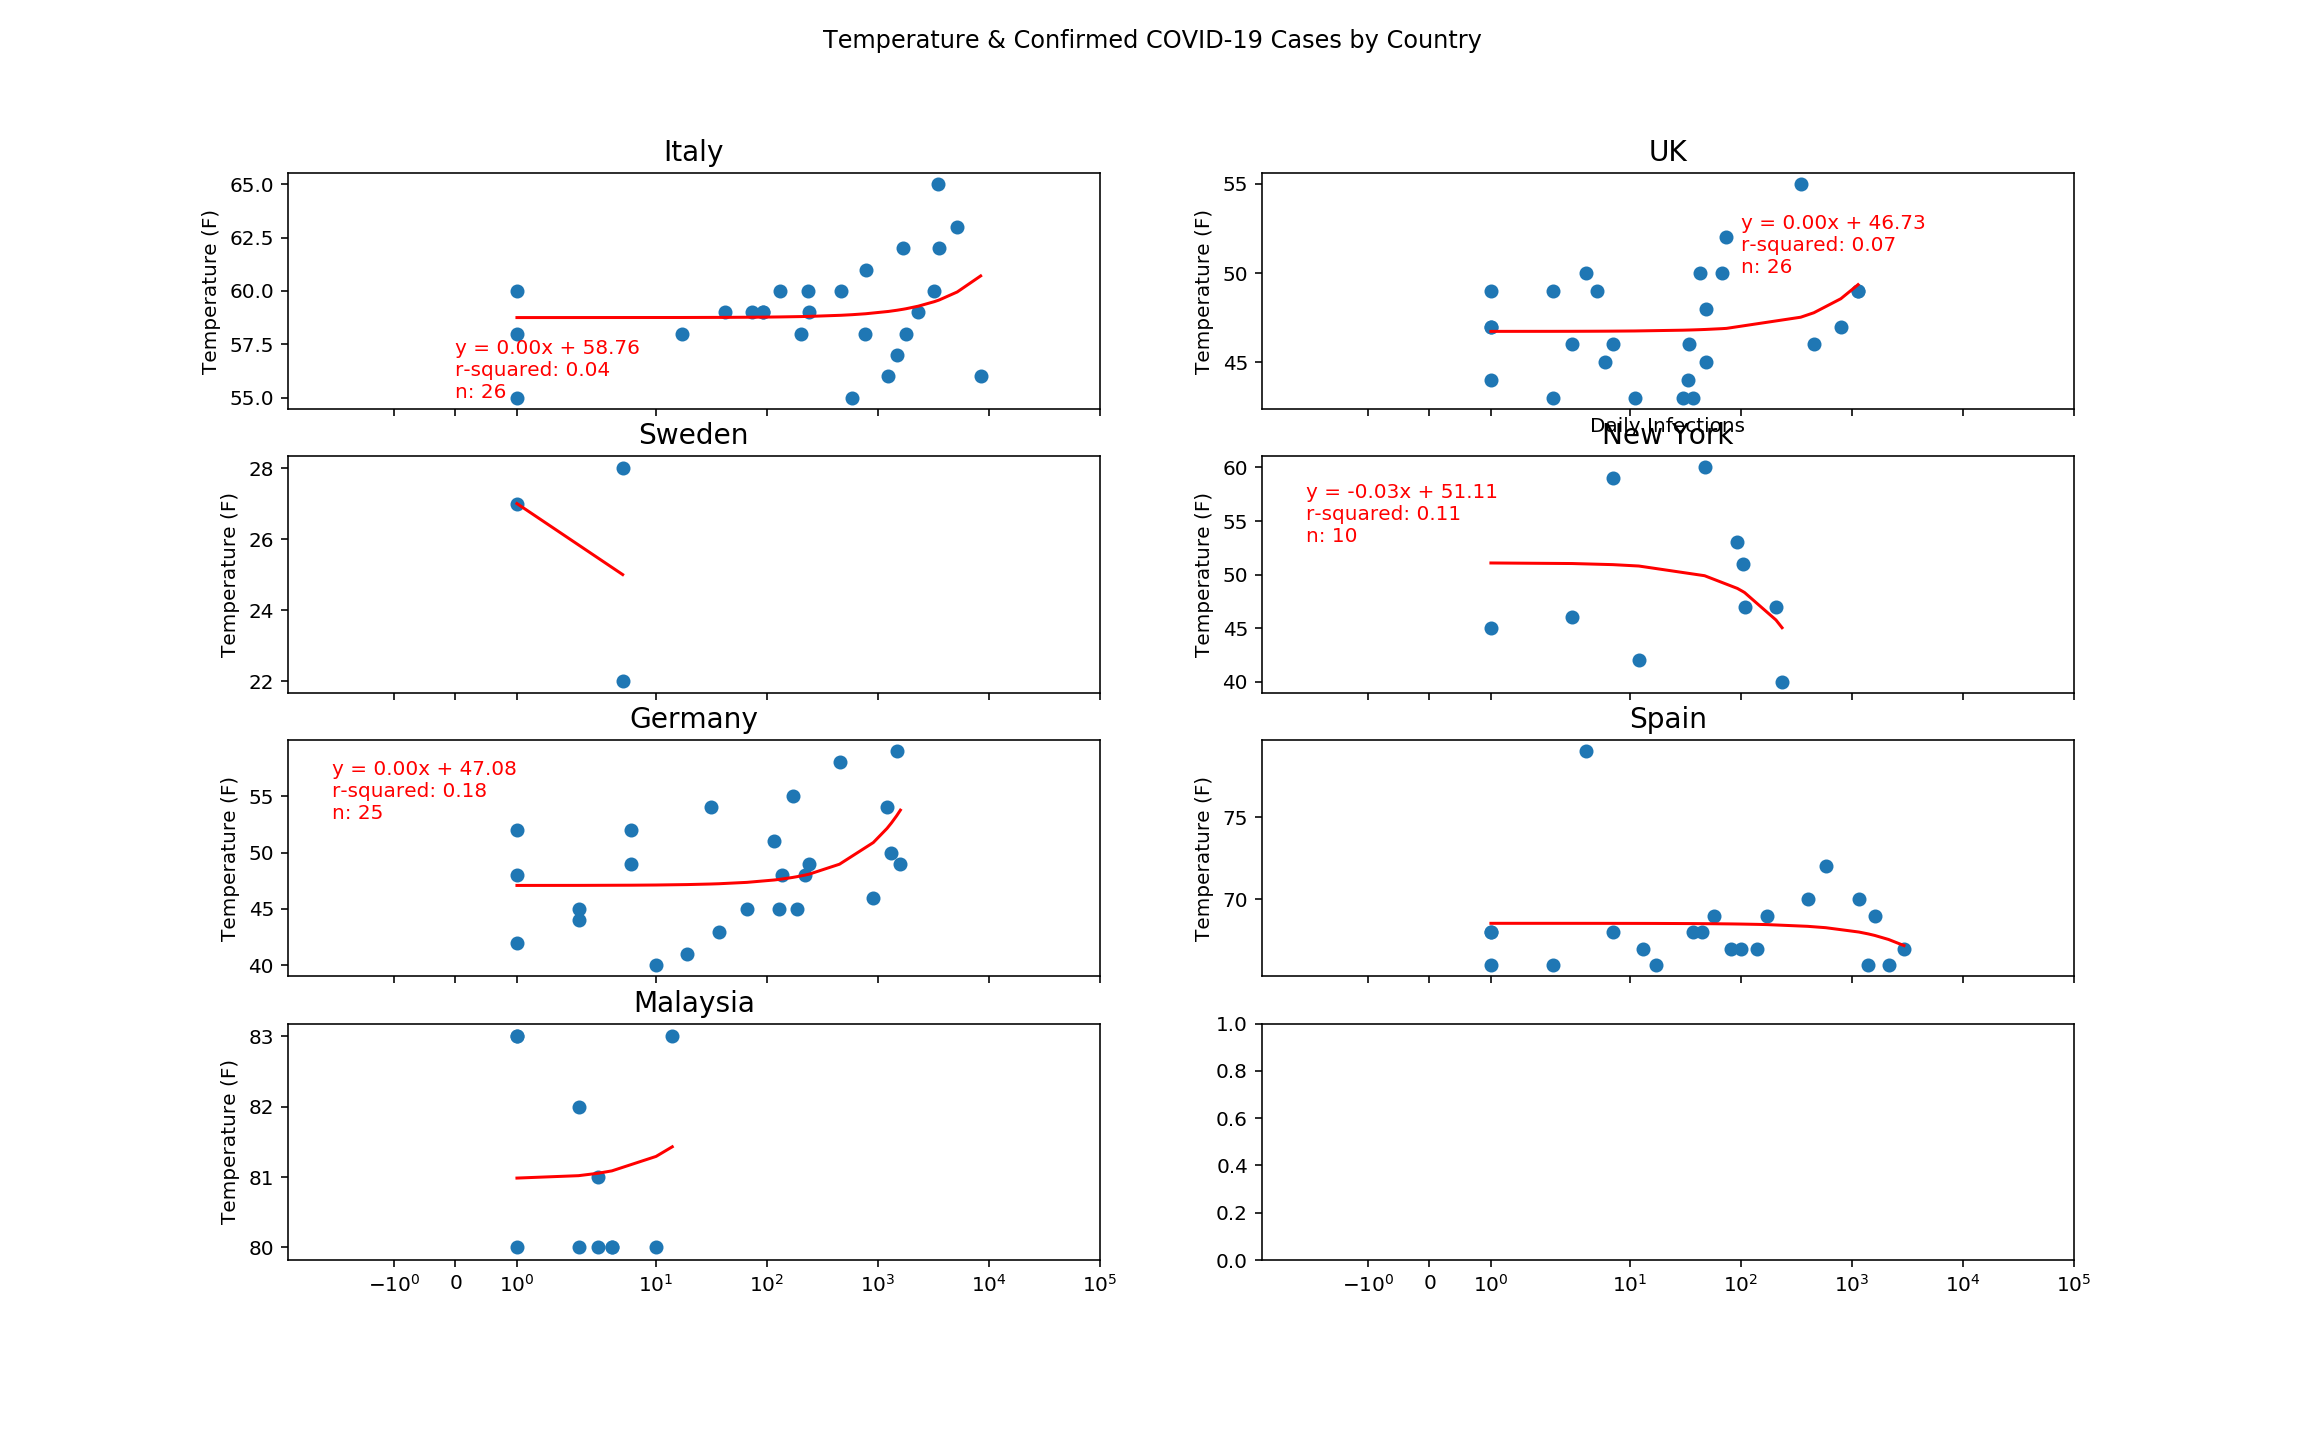

In [24]:
#Graph each country individually in one figure
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4,2,sharex=True, figsize=(16,10))

plotRegression(ax1[0],df_italy.daily_confirm, df_italy["Avg Temp (F)"],graph_title="Italy", ylabel="Temperature (F)", labelpos=(0,55))
plotRegression(ax1[1],df_uk.daily_confirm, df_uk["Avg Temp (F)"],graph_title="UK", ylabel="Temperature (F)",xlabel="Daily Infections", labelpos=(100,50))

plotRegression(ax2[0],df_swd.daily_confirm, df_swd["Avg Temp (F)"],graph_title="Sweden", ylabel="Temperature (F)", labelpos=(-5,53))
plotRegression(ax2[1],df_ny.daily_confirm, df_ny["Avg Temp (F)"],graph_title="New York", ylabel="Temperature (F)", labelpos=(-2,53))

plotRegression(ax3[0],df_germ.daily_confirm, df_germ["Avg Temp (F)"],graph_title="Germany", ylabel="Temperature (F)", labelpos=(-2,53))
plotRegression(ax3[1],df_spain.daily_confirm, df_spain["Avg Temp (F)"],graph_title="Spain", ylabel="Temperature (F)", labelpos=(0,53))

plotRegression(ax4[0],df_mly.daily_confirm, df_mly["Avg Temp (F)"],graph_title="Malaysia", ylabel="Temperature (F)", labelpos=(-30,53))


fig.suptitle("Temperature & Confirmed COVID-19 Cases by Country")

ax1[0].set_xlim(-50,1000)
ax1[1].set_xlim(-50,1000)
ax2[0].set_xlim(-500,1000)
ax2[1].set_xlim(-50,1000)
ax3[0].set_xlim(-50,1000)
ax3[1].set_xlim(-50,1000)
ax4[0].set_xlim(-50,1000)



ax1[0].set_xscale("symlog")
ax1[1].set_xscale("symlog")
ax2[0].set_xscale("symlog")
ax2[1].set_xscale("symlog")
ax3[0].set_xscale("symlog")
ax3[1].set_xscale("symlog")
ax4[1].set_xscale("symlog")

plt.xlim((-5,100000))
plt.savefig("Individual Countries Charted.png")
plt.show()

<IPython.core.display.Javascript object>


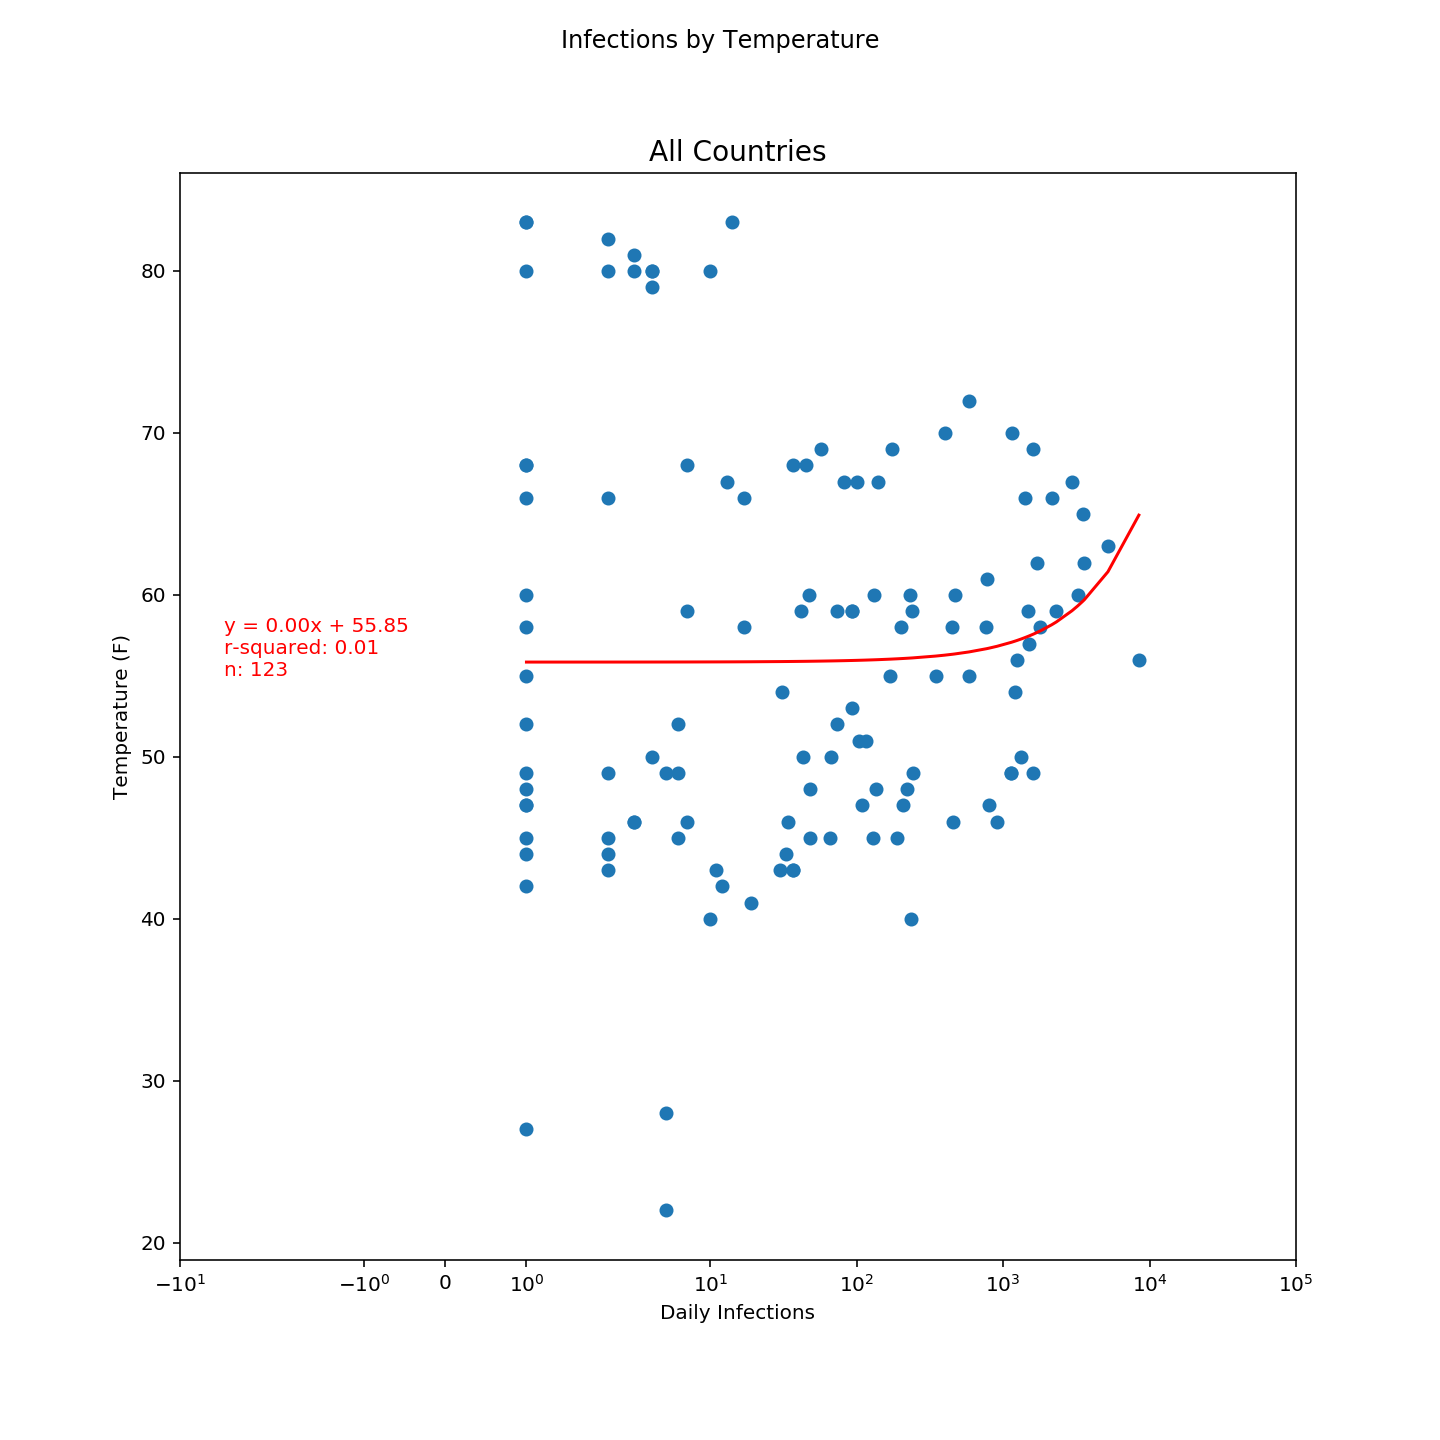

In [25]:
#Look at all the countries 
fig, ax1 = plt.subplots(1,1, figsize=(10,10))

plotRegression(ax1,total_df.daily_confirm, total_df["Avg Temp (F)"],graph_title="All Countries", xlabel = "Daily Infections", ylabel="Temperature (F)", labelpos=(-5,55))
fig.suptitle("Infections by Temperature")


ax1.set_xlim(-10,100000)

ax1.set_xscale("symlog")
plt.xlim((-5,100000))
plt.savefig("All Countries Charted.png")
plt.show()



Data Exploration: Notes
    
Usually, data exploration comes before the analysis. I wasn't able to complete my exploration due to time constraints, but would be interested in exploring:

- Grouping country data into three groups, based on hot, mild and cold temperatures
- Looking at temperature vs recovery and death rates (although data is even more limited for these categories)

Outside research:
- More countries, including the US and China
- Data on how long the virus survives outside of the body 